**Problem:** 
Calculate the mass of the mountain region of Almaty, Kazakhstan and in process suggest a way to measure the gravitational constant $G$.

**Remarks:**
- Almaty geo was taken from https://github.com/akilbekov/almaty.geo.json
- used the open-meteo API to get the elevation of the points

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import folium

from scipy.interpolate import griddata


# load the "almaty.geo.json" file
almaty = gpd.read_file("almaty.geo.json")


m = folium.Map(location=(43.238949, 76.889709), zoom_start=12)

# add the "almaty" GeoDataFrame to the map
folium.GeoJson(almaty).add_to(m)

# display the map
m

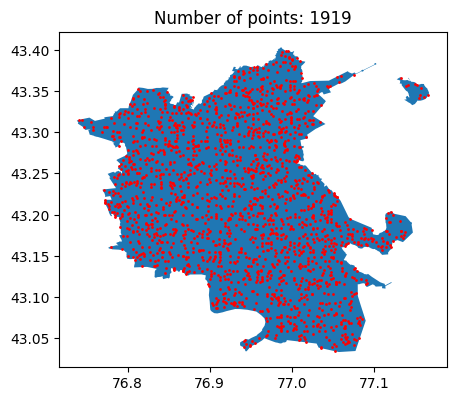

In [13]:
# sample evenly N points from the polygon
N = 2000

# get grid with N points that fit into the bounding box of the polygon
xmin, ymin, xmax, ymax = almaty.total_bounds

x = np.random.uniform(xmin, xmax, 2 * N).round(3)
y = np.random.uniform(ymin, ymax, 2 * N).round(3)

# create a GeoDataFrame with the points
points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x, y))

# select only the points that are within the polygon
points_within = points[points.within(almaty.loc[0, 'geometry'])]

# unique the points
points_within = points_within.drop_duplicates()

# plot the points
ax = almaty.plot()
points_within.plot(ax=ax, color='red', markersize=1)
plt.title(f"Number of points: {len(points_within)}")
plt.gcf().set_size_inches(5, 5)

In [25]:
%%script false --no-raise-error
# skipping this cell, as we have the data already

# use the API to get the point elevation
# https://api.open-meteo.com/v1/elevation?latitude=52.52&longitude=13.41
import requests
import json

def get_elevation(lat, lon):
    url = f"https://api.open-meteo.com/v1/elevation?latitude={lat}&longitude={lon}"
    response = requests.get(url)
    return response.json()['elevation'][0]

def reset_buffer():
    return pd.DataFrame(columns=['lat', 'lon', 'elevation'])


FILENAME = 'elevations.csv'
buffer = reset_buffer()

if not os.path.exists(FILENAME):
    buffer.to_csv(FILENAME, index=False)

for i, row in tqdm(points_within.iterrows(), total=len(points_within)):
    lat, lon = row['geometry'].y, row['geometry'].x
    elevation = get_elevation(lat, lon)

    if elevation is None: 
        continue
    
    new_row = pd.DataFrame({'lat': [lat], 'lon': [lon], 'elevation': [elevation]})
    buffer = pd.concat([buffer, new_row])

    if i % 50 == 0:
        buffer.to_csv(FILENAME, index=False, header=False, mode='a')
        buffer = reset_buffer()

Text(0.5, 1.0, 'Number of points: 1562')

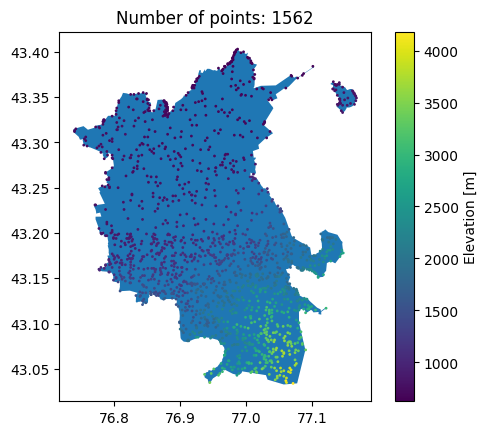

In [26]:
# load the buffer
elevation = pd.read_csv('elevations.csv')

# plot the elevation
ax = almaty.plot()

# make a scatter plot
sc = ax.scatter(elevation['lon'], elevation['lat'], c=elevation['elevation'], cmap='viridis', s=1)
plt.colorbar(sc, label='Elevation [m]') 
plt.title(f"Number of points: {len(elevation)}")

In [27]:
N_SAMPLES = 100

# mesh grid
x = np.linspace(xmin, xmax, N_SAMPLES)
y = np.linspace(ymin, ymax, N_SAMPLES)

X, Y = np.meshgrid(x, y)

# interpolate the elevation
Z = griddata(
    (elevation['lon'], elevation['lat']), 
    elevation['elevation'], 
    (X, Y), 
    method='cubic'
)

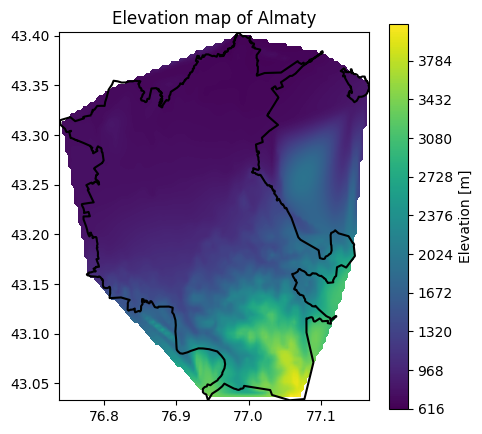

In [28]:
# plot the elevation
n_colors = 500
plt.figure(figsize=(5, 5))
plt.contourf(X, Y, Z, n_colors, cmap='viridis')
plt.colorbar(label='Elevation [m]')
plt.title('Elevation map of Almaty')
almaty.boundary.plot(ax=plt.gca(), color='black')
plt.show()

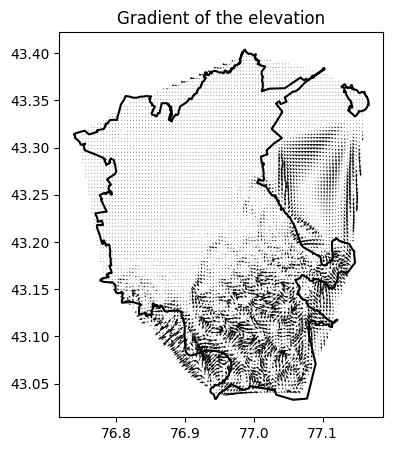

In [29]:
# plot the gradient of the elevation
dx, dy = np.gradient(Z)

plt.figure(figsize=(5, 5))
plt.quiver(X, Y, dx, dy)
plt.title('Gradient of the elevation')
almaty.boundary.plot(ax=plt.gca(), color='black')
plt.show()

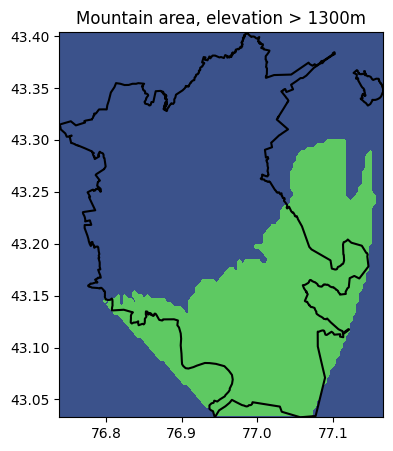

In [30]:
# select the mountain based on if the elevation is higher than 1300m
BASE_ELEVATION = 1300

is_mountain = Z > BASE_ELEVATION

plt.figure(figsize=(5, 5))
plt.contourf(X, Y, is_mountain, cmap='viridis')
plt.title('Mountain area, elevation > 1300m')
almaty.boundary.plot(ax=plt.gca(), color='black')
plt.show()

In [31]:
# compute the volume of the mountain region using the elevation map
volume = is_mountain * (Z - BASE_ELEVATION)

# replace the NaN values with 0
volume = np.nan_to_num(volume)

# compute the volume
# dx, dy are distances between the points in the grid (in meters)

# distance between the xmin and xmax in longitude converted to meters
dx = 111 * 1000 * (xmax - xmin) * np.cos((ymin + ymax) / 2) / N_SAMPLES
dy = 111 * 1000 * (ymax - ymin) * np.cos((xmin + xmax) / 2) / N_SAMPLES

volume = volume.sum() * dx * dy

print(f"The volume of the Almaty mountain region is {volume:,.0f} m^3")

The volume of the Almaty mountain region is 5,684,097,774 m^3


Most common mountain rocks in Almaty are:
- granite 2600 kg/m^3
- granodiorite 2700-2900 kg/m^3
- syenites 2600-2750 kg/m^3 


In [32]:
average_density = 2700 # kg/m^3

# compute the mass of the mountain
mass = volume * average_density

print(
    f"The mass of the Almaty mountain region is {mass:,.0f} kg",
    f"or {mass / 1e12:,.0f} trillion kg",
)

The mass of the Almaty mountain region is 15,347,063,989,370 kg or 15 trillion kg


It is suggested that the constant $G$ could be measured by the deflection from the vertical of a suspended mass and the mass of a mountain. The whole mass of the mountain, may be considered to act at its centre of mass.

<p align="center">
    <img src="./example.jpg">
</p>

In [33]:
m1 = mass
m2 = 20 / 1000 # 20g (a coin)
r = 2000 # 2km = 2000m

G = 6.67430e-11 # m^3 kg^-1 s^-2

F = G * m1 * m2 / r**2

theta = np.arctan(F / (m2 * 9.81))
theta * 180 / np.pi # in degrees

0.0014956316989328277

If we had to measure the deflection angle in real life, it would be approximately $1.5 \cdot 10^{-3}$ degrees